## This notebook performs some data analysis of the LLC2160 data using the OpenVisus framework.

## **Step 1: Importing the libraries**

In [1]:
import numpy as np
import openvisuspy as ovp
import matplotlib.pyplot as plt
import os
os.environ['VISUS_CACHE']= "./visus_can_be_deleted"

## **Step 2: Reading the metadata file from cloud**
In this section, we define the url locations of the three velocity fields (u, v, w) of the dataset. We then load this data with `LoadDataset`.

In [4]:
# LLC2160 data
u_url = "https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_arco/visus.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
w_url = "https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_w/llc2160_w.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
v_url = "https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_v/v_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
salinity_url ="https://maritime.sealstorage.io/api/v0/s3/utah/nasa/dyamond/mit_output/llc2160_salt/salt_llc2160_x_y_depth.idx?access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"

urls = [u_url, w_url, v_url, salinity_url]

In [6]:
dbs =  {}
for url in urls:
    db=ovp.LoadDataset(url)
    print(f'Dimensions: {db.getLogicBox()[1][0]}*{db.getLogicBox()[1][1]}*{db.getLogicBox()[1][2]}')
    print(f'Total Timesteps: {len(db.getTimesteps())}')
    field = db.getField().name
    print(f'Field: {field}')
    print('Data Type: float32')
    dbs[field] = db

Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: u
Data Type: float32
Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: w
Data Type: float32
Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: v
Data Type: float32
Dimensions: 8640*6480*90
Total Timesteps: 10366
Field: salt
Data Type: float32


#### Load in depth metadata from depth_levels.txt
This contains the depth level in meters for each of the 90 levels, with one value on each line of the file.

In [9]:
with open('depth_levels.txt', 'r') as f:
    depth_levels = [float(line.strip()) for line in f]
print(depth_levels)

[0.5, 1.6, 2.8, 4.2, 5.8, 7.6, 9.7, 12.0, 14.7, 17.7, 21.1, 25.0, 29.3, 34.2, 39.7, 45.8, 52.7, 60.3, 68.7, 78.0, 88.2, 99.4, 112.0, 125.0, 139.0, 155.0, 172.0, 190.0, 209.0, 230.0, 252.0, 275.0, 300.0, 325.0, 352.0, 381.0, 410.0, 441.0, 473.0, 507.0, 541.0, 576.0, 613.0, 651.0, 690.0, 730.0, 771.0, 813.0, 856.0, 900.0, 946.0, 992.0, 1040.0, 1089.0, 1140.0, 1192.0, 1246.0, 1302.0, 1359.0, 1418.0, 1480.0, 1544.0, 1611.0, 1681.0, 1754.0, 1830.0, 1911.0, 1996.0, 2086.0, 2181.0, 2281.0, 2389.0, 2503.0, 2626.0, 2757.0, 2898.0, 3050.0, 3215.0, 3392.0, 3584.0, 3792.0, 4019.0, 4266.0, 4535.0, 4828.0, 5148.0, 5499.0, 5882.0, 6301.0, 6760.0]


## **East-West Velocity (u) Analysis: Single Timestep**
We choose quality=0 to analyze the full resolution data. We choose only a single timestep because it is already over 20GB (~5B data points * 4 bytes per point (float32)). The velocity values are in m/s.

#### Warning: the following cell loads a full resolution timestep which is about 20.15GB

In [8]:
u_data = dbs['u'].db.read(time=0, quality=0)

In [14]:
print(f"u_data.shape: {u_data.shape}")
print(f"u_data.dtype: {u_data.dtype}")

u_data.shape: (90, 6480, 8640)
u_data.dtype: float32


In [51]:
nan_count = np.sum(np.isnan(u_data))
print(f"Total NaN values: {nan_count}")

Total NaN values: 0


In [41]:
zero_count = np.sum((u_data == 0).astype(np.uint32)) # cast to uint32 to prevent integer overflow
percentage_zero_points = zero_count/u_data.size
print(f"Total zero values: {zero_count}")
print(f"Total values: {u_data.size}")
print(f"Percentage zero values of all data points: {percentage_zero_points}")

Total zero values: 2715638055
Total values: 5038848000
Percentage zero values of all data points: 0.5389402607500762


In [43]:
print(f"Mean: {np.mean(u_data)}")
print(f"Median: {np.median(u_data)}")
print(f"Min:{np.min(u_data)}")
print(f"Max: {np.max(u_data)}")
print(f"Standard Deviation: {np.std(u_data)}")
print(f"Variance: {np.var(u_data)}")
print(f"25th Percentile: {np.percentile(u_data, 25)}")
print(f"75th Percentile: {np.percentile(u_data, 75)}")

Mean: 0.0050828359089791775
Median: 0.0
Min:-6.638339519500732
Max: 4.987942695617676
Standard Deviation: 0.08878987282514572
Variance: 0.007883640937507153
25th Percentile: 0.0
75th Percentile: 0.0


Obtain metrics for **nonzero** data points

In [45]:
non_zero_u_data = u_data[u_data != 0]

print(f"Number of non-zero elements: {non_zero_u_data.size}")
print(f"Mean: {np.mean(non_zero_u_data)}")
print(f"Median: {np.median(non_zero_u_data)}")
print(f"Min: {np.min(non_zero_u_data)}")
print(f"Max: {np.max(non_zero_u_data)}")
print(f"Standard Deviation: {np.std(non_zero_u_data)}")
print(f"Variance: {np.var(non_zero_u_data)}")
print(f"25th Percentile: {np.percentile(non_zero_u_data, 25)}")
print(f"75th Percentile: {np.percentile(non_zero_u_data, 75)}")

Number of non-zero elements: 2323209945
Mean: 0.011024386622011662
Median: 0.004750885535031557
Min: -6.638339519500732
Max: 4.987942695617676
Standard Deviation: 0.13056856393814087
Variance: 0.017048150300979614
25th Percentile: -0.04044433310627937
75th Percentile: 0.05358494445681572


#### Calculate the percentage of data points that equal zero for each depth slice

In [83]:
zero_percentages = []
total_count = u_data[0].size
# create zero_percentages list with percentage of data points equal to zero for each depth slice
for depth in range(u_data.shape[0]):
    zero_count = np.sum(u_data[depth]==0)
    zero_percentages.append(zero_count/total_count)

As we can see in the following graph, the percentage of points in each slice that are zero increase with depth. This is expected since as we go deeper in the ocean we will encounter more underwater land formations. The points that are land are just given the value 0. Once we reach 6km, the percentage of zero points is very high. This makes sense since we expect there to only be some ocean trenches that reach this level.

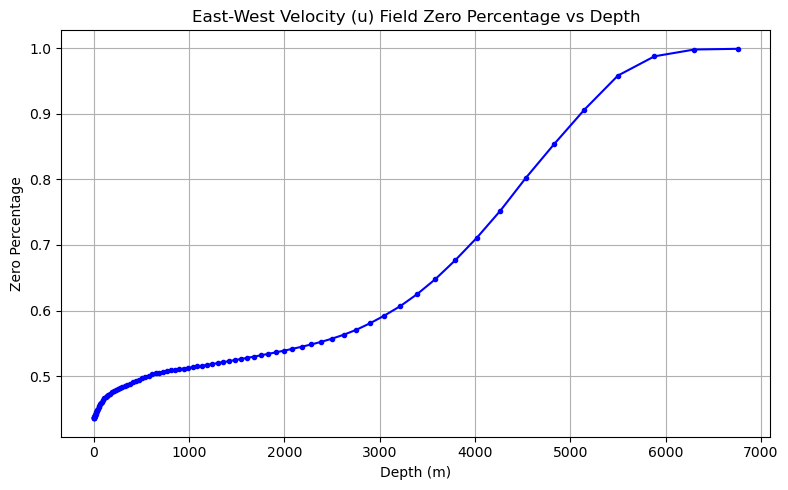

In [158]:
# plot the zero percentages across depth
plt.figure(figsize=(8, 5))
plt.plot(depth_levels, zero_percentages, marker='o', linestyle='-', color='blue', ms=3)
plt.xlabel("Depth (m)")
plt.ylabel("Zero Percentage")
plt.title("East-West Velocity (u) Field Zero Percentage vs Depth")
plt.grid(True)
plt.tight_layout()
plt.show()

In [125]:
only_u_zero = 0
# go through each depth slice and count number of points where u==0 and salt!=0
for depth in range(u_data.shape[0]):
    print(f"counting depth={depth}")
    salt_data = dbs['salt'].db.read(time=0, quality=0, z=[depth, depth+1])
    only_u_zero += np.sum((u_data[depth] == 0) & (salt_data != 0))
print(only_u_zero)

counting depth=0
counting depth=1
counting depth=2
counting depth=3
counting depth=4
counting depth=5
counting depth=6
counting depth=7
counting depth=8
counting depth=9
counting depth=10
counting depth=11
counting depth=12
counting depth=13
counting depth=14
counting depth=15
counting depth=16
counting depth=17
counting depth=18
counting depth=19
counting depth=20
counting depth=21
counting depth=22
counting depth=23
counting depth=24
counting depth=25
counting depth=26
counting depth=27
counting depth=28
counting depth=29
counting depth=30
counting depth=31
counting depth=32
counting depth=33
counting depth=34
counting depth=35
counting depth=36
counting depth=37
counting depth=38
counting depth=39
counting depth=40
counting depth=41
counting depth=42
counting depth=43
counting depth=44
counting depth=45
counting depth=46
counting depth=47
counting depth=48
counting depth=49
counting depth=50
counting depth=51
counting depth=52
counting depth=53
counting depth=54
counting depth=55
co

The percentage of points where u==0 and salt!=0 is very low (~0.128%). The points where salt is 0 indicate land. We decide that we will treat velocity vector values that equal 0 as land since there are relatively few that give a false positive. This saves us from having to load the salt data as well, reducing transfer times and memory requirements.

In [127]:
print(f"Percentage of all points where u==0 and salt!=0: {only_u_zero/u_data.size}")

Percentage of all points where u==0 and salt!=0: 0.0012819227728242647


In [136]:
mean_across_depth = []
std_across_depth = []
# go through each depth slice and calculate the mean and std for nonzero values
for depth in range(u_data.shape[0]):
    nonzero_slice = u_data[depth][u_data[depth] != 0]
    print(f"processing depth={depth}")
    mean_across_depth.append(np.mean(nonzero_slice))
    std_across_depth.append(np.std(nonzero_slice))

processing depth=0
processing depth=1
processing depth=2
processing depth=3
processing depth=4
processing depth=5
processing depth=6
processing depth=7
processing depth=8
processing depth=9
processing depth=10
processing depth=11
processing depth=12
processing depth=13
processing depth=14
processing depth=15
processing depth=16
processing depth=17
processing depth=18
processing depth=19
processing depth=20
processing depth=21
processing depth=22
processing depth=23
processing depth=24
processing depth=25
processing depth=26
processing depth=27
processing depth=28
processing depth=29
processing depth=30
processing depth=31
processing depth=32
processing depth=33
processing depth=34
processing depth=35
processing depth=36
processing depth=37
processing depth=38
processing depth=39
processing depth=40
processing depth=41
processing depth=42
processing depth=43
processing depth=44
processing depth=45
processing depth=46
processing depth=47
processing depth=48
processing depth=49
processing

The following graph shows the mean and standard deviation of the nonzero velocity values across depth levels. In the shallow layers, we can see the standard deviation is the highest. This is expected since the atmosphere and sunlight (causing temperature changes) can likely have a larger impact on the velocity, so there is more variance at these levels. As we go deeper, the standard deviation decreases. The mean and standard deviation are less stable at the deepest levels since there are fewer nonzero points.

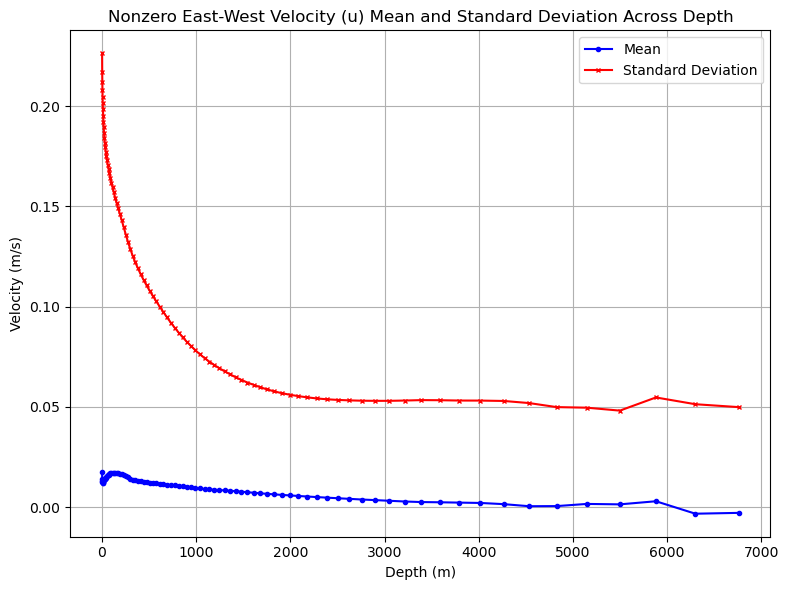

In [161]:
# plot the mean and standard deviation of nonzero values for each depth level
plt.figure(figsize=(8, 6))

plt.plot(depth_levels, mean_across_depth, label="Mean", color='blue', marker='o', markersize=3)
plt.plot(depth_levels, std_across_depth, label="Standard Deviation", color='red', marker='x', markersize=3)

plt.xlabel("Depth (m)")
plt.ylabel("Velocity (m/s)")
plt.title("Nonzero East-West Velocity (u) Mean and Standard Deviation Across Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [168]:
# remove u_data from memory - optional
#del u_data

## **North-South Velocity (v) Analysis: Single Timestep**
We choose quality=0 to analyze the full resolution data. We choose only a single timestep because it is already over 20GB (~5B data points * 4 bytes per point (float32)). The velocity values are in m/s.

#### Warning: the following cell loads a full resolution timestep which is about 20.15GB

In [11]:
v_data = dbs['v'].db.read(time=0, quality=0)

In [18]:
print(f"v_data.shape: {v_data.shape}")
print(f"v_data.dtype: {v_data.dtype}")

v_data.shape: (90, 6480, 8640)
v_data.dtype: float32


In [20]:
nan_count = np.sum(np.isnan(v_data))
print(f"Total NaN values: {nan_count}")

Total NaN values: 0


In [21]:
zero_count = np.sum((v_data == 0).astype(np.uint32)) # cast to uint32 to prevent integer overflow
percentage_zero_points = zero_count/v_data.size
print(f"Total zero values: {zero_count}")
print(f"Total values: {v_data.size}")
print(f"Percentage zero values of all data points: {percentage_zero_points}")

Total zero values: 2715300691
Total values: 5038848000
Percentage zero values of all data points: 0.5388733081450363


In [22]:
print(f"Mean: {np.mean(v_data)}")
print(f"Median: {np.median(v_data)}")
print(f"Min:{np.min(v_data)}")
print(f"Max: {np.max(v_data)}")
print(f"Standard Deviation: {np.std(v_data)}")
print(f"Variance: {np.var(v_data)}")
print(f"25th Percentile: {np.percentile(v_data, 25)}")
print(f"75th Percentile: {np.percentile(v_data, 75)}")

Mean: -0.0008345379028469324
Median: 0.0
Min:-6.3791327476501465
Max: 5.649183750152588
Standard Deviation: 0.08148784935474396
Variance: 0.006640269421041012
25th Percentile: 0.0
75th Percentile: 0.0


Obtain metrics for **nonzero** data points

In [24]:
non_zero_v_data = v_data[v_data != 0]

print(f"Number of non-zero elements: {non_zero_v_data.size}")
print(f"Mean: {np.mean(non_zero_v_data)}")
print(f"Median: {np.median(non_zero_v_data)}")
print(f"Min: {np.min(non_zero_v_data)}")
print(f"Max: {np.max(non_zero_v_data)}")
print(f"Standard Deviation: {np.std(non_zero_v_data)}")
print(f"Variance: {np.var(non_zero_v_data)}")
print(f"25th Percentile: {np.percentile(non_zero_v_data, 25)}")
print(f"75th Percentile: {np.percentile(non_zero_v_data, 75)}")

Number of non-zero elements: 2323547309
Mean: -0.0018097630236297846
Median: -0.0022527887485921383
Min: -6.3791327476501465
Max: 5.649183750152588
Standard Deviation: 0.12000293284654617
Variance: 0.014400703832507133
25th Percentile: -0.04308881610631943
75th Percentile: 0.03932156786322594


Calculate the percentage of data points that equal zero for each depth slice

In [26]:
zero_percentages = []
total_count = v_data[0].size
# create zero_percentages list with percentage of data points equal to zero for each depth slice
for depth in range(v_data.shape[0]):
    zero_count = np.sum(v_data[depth]==0)
    zero_percentages.append(zero_count/total_count)

As we can see in the following graph, the percentage of points in each slice that are zero increase with depth, similar to the East-West Velocity. This is expected since as we go deeper in the ocean we will encounter more underwater land formations. The points that are land are just given the value 0. Once we reach 6km, the percentage of zero points is very high. This makes sense since we expect there to only be some ocean trenches that reach this level.

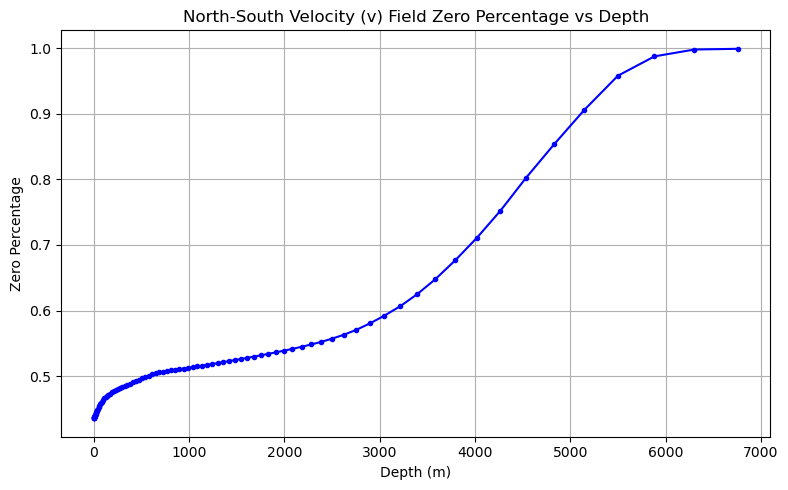

In [28]:
# plot the zero percentages across depth
plt.figure(figsize=(8, 5))
plt.plot(depth_levels, zero_percentages, marker='o', linestyle='-', color='blue', ms=3)
plt.xlabel("Depth (m)")
plt.ylabel("Zero Percentage")
plt.title("North-South Velocity (v) Field Zero Percentage vs Depth")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
mean_across_depth = []
std_across_depth = []
# go through each depth slice and calculate the mean and std for nonzero values
for depth in range(v_data.shape[0]):
    nonzero_slice = v_data[depth][v_data[depth] != 0]
    print(f"processing depth={depth}")
    mean_across_depth.append(np.mean(nonzero_slice))
    std_across_depth.append(np.std(nonzero_slice))

processing depth=0
processing depth=1
processing depth=2
processing depth=3
processing depth=4
processing depth=5
processing depth=6
processing depth=7
processing depth=8
processing depth=9
processing depth=10
processing depth=11
processing depth=12
processing depth=13
processing depth=14
processing depth=15
processing depth=16
processing depth=17
processing depth=18
processing depth=19
processing depth=20
processing depth=21
processing depth=22
processing depth=23
processing depth=24
processing depth=25
processing depth=26
processing depth=27
processing depth=28
processing depth=29
processing depth=30
processing depth=31
processing depth=32
processing depth=33
processing depth=34
processing depth=35
processing depth=36
processing depth=37
processing depth=38
processing depth=39
processing depth=40
processing depth=41
processing depth=42
processing depth=43
processing depth=44
processing depth=45
processing depth=46
processing depth=47
processing depth=48
processing depth=49
processing

The following graph shows the mean and standard deviation of the nonzero velocity values across depth levels. The graph is similar to the East-West Velocity mean and standard deviation graph. In the shallow layers, we can see the standard deviation is the highest. This is expected since the atmosphere and sunlight (causing temperature changes) can likely have a larger impact on the velocity, so there is more variance at these levels. As we go deeper, the standard deviation decreases. The mean and standard deviation are less stable at the deepest levels since there are fewer nonzero points.

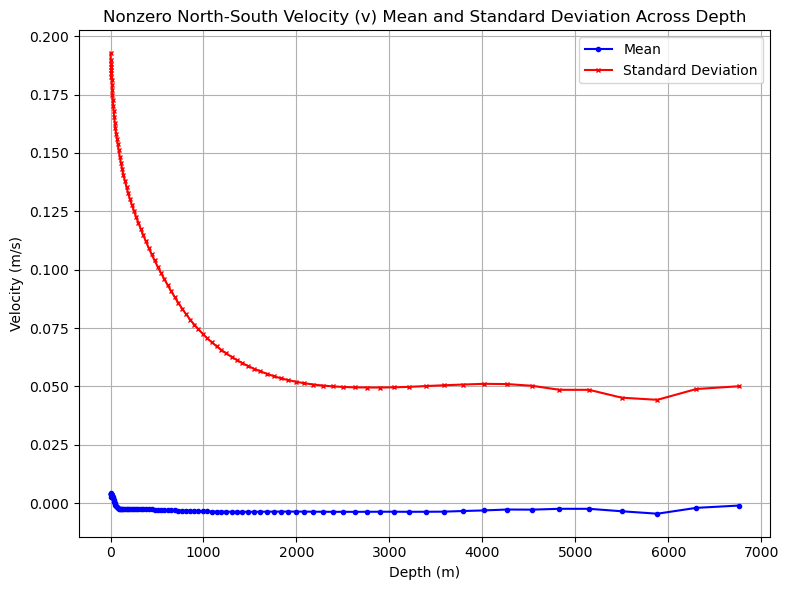

In [32]:
# plot the mean and standard deviation of nonzero values for each depth level
plt.figure(figsize=(8, 6))

plt.plot(depth_levels, mean_across_depth, label="Mean", color='blue', marker='o', markersize=3)
plt.plot(depth_levels, std_across_depth, label="Standard Deviation", color='red', marker='x', markersize=3)

plt.xlabel("Depth (m)")
plt.ylabel("Velocity (m/s)")
plt.title("Nonzero North-South Velocity (v) Mean and Standard Deviation Across Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()